# Imports

In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Testset Modification (Addition of anomalies)

In [2]:
df = pd.read_csv("data/mnist_test.csv")
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Arbitrarily choose first 1000 for corruption

anom = df[:1000]
clean = df[1000:]

In [4]:
# Function for displaying the MNIST image

def show_mnist_image(data):
    # The first column is the label
    label = data[0]
    
    # The rest of columns are pixels
    pixels = data[1:]
    
    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(pixels, dtype='int64')
    #print(pixels.shape)
    
    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((28, 28))
    #print(pixels.shape)
    
    # Plot
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap='gray')
    plt.show();

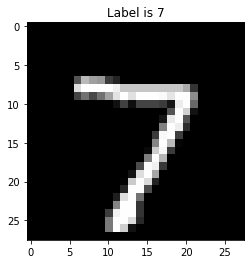

In [5]:
show_mnist_image(df.iloc[0])

In [ ]:
# Apply corruption

for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [ ]:
# Change the label (1 for anomaly, 0 for clean)

anom.loc[:, 'label'] = 1
clean.loc[:, 'label'] = 0

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.array(clean.iloc[0, 1:]).reshape(28, 28), cmap='gray')
axs[1].imshow(np.array(anom.iloc[0, 1:]).reshape(28, 28), cmap='gray')

plt.show();

In [ ]:
# Recombine the test sets

an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('data/anom.csv')          # save